In [11]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import pathlib
import re

def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

In [2]:
def draw_organ(ax, array, color = 'b'):
    N = array.shape[0]
    for i in range(0, N):
        x, y = array[i,:]
        circ = plt.Circle((x, y), radius=3, color=color, fill = True)
        ax.add_patch(circ)
    return

def draw_lines(ax, array, color = 'b'):
    N = array.shape[0]
    for i in range(0, N):
        x1, y1 = array[i-1,:]
        x2, y2 = array[i,:]
        ax.plot([x1, x2], [y1, y2], color=color, linestyle='-', linewidth=1)
    return

def drawOrgans(RL, LL, H = None, img =  None):
    fig, ax = plt.subplots()
    
    if img is not None:
        plt.imshow(img, cmap='gray')
    else:
        img = np.zeros([1024, 1024])
        plt.imshow(img)
    
    plt.axis('off')
    
    draw_lines(ax, RL, 'r')
    draw_lines(ax, LL, 'g')
    
    draw_organ(ax, RL, 'r')
    draw_organ(ax, LL, 'g')
    
    if H is not None:
        draw_lines(ax, H, 'y')
        draw_organ(ax, H, 'y')

    return

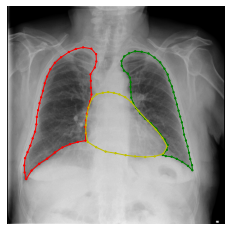

In [3]:
data_root = pathlib.Path("Images/")
all_files = list(data_root.glob('*.png'))
all_files = [str(path) for path in all_files]
all_files.sort(key = natural_key)

img1 = all_files[0]
RL = img1.replace('Images','landmarks/RL').replace('.png','.npy')
LL = img1.replace('Images','landmarks/LL').replace('.png','.npy')
H = img1.replace('Images','landmarks/H').replace('.png','.npy')

img = cv2.imread(img1,0)
RL = np.load(RL)
LL = np.load(LL)
H = np.load(H)

drawOrgans(RL,LL,H,img)

In [5]:
from csv import reader, excel_tab

def clean_csv_file(file_path, file_type):
    """ This function cleans the csv data present along with the image file. The data is removed of inappropriate
    splits and combined into a 10 element list for images with nodules and 4 element list for images without
    nodules.
    csv content is formatted into [filename, degree of subtlety, nodule size [mm], age, sex, x coordinate
    of the nodule, y coordinate of the nodule, pathology, position, diagnosis] format for images with nodules
    and [filename, age, sex, diagnosis("non-nodule")] format for non-nodule images respectively.
    Args:
        file_path (str) : Path to the CSV file for nodule and non-nodule images.
        file_type (str) : If file_path is to nodule images, then file_type is "nodule csv" and if file_path is to
                          non-nodule images, then file_type is "non nodule csv".
    Returns:
        csv_data (dict): csv_data returns a dict of the form { 'filename' : 'filename' image's csv data }.
        Example:
            { "./All247images/JPCNN010.IMG" : ['JPCNN010.IMG', '54', 'male', 'non-nodule'] }
    """
    csv_data = {}
    if file_type == "nodule csv":
        with open(file_path, "rU") as csv_file:
            content = reader(csv_file, dialect=excel_tab)
            for row in content:
                if len(row) != 0:
                    row[8:10] = [" ".join(row[8:10])]
                    row[9:] = [" ".join(row[9:])]
                    csv_data[row[0]] = row
        return csv_data
    elif file_type == "non nodule csv":
        with open(file_path, "rU") as csv_file:
            content = reader(csv_file, dialect=excel_tab)
            for row in content:
                if len(row) != 0:
                    row = row[0].split(" ")
                    new_row = []
                    new_row.extend([row[0], row[1], row[3], row[len(row) - 1]])
                    csv_data[new_row[0]] = new_row
        return csv_data
    else:
        return csv_data
    

csv_data_nodule = clean_csv_file("../JSRT/Clinical_Information/CLNDAT_EN.txt", "nodule csv")
csv_data_nodule = {kv[0].replace('.IMG','.png'):kv[1] for kv in csv_data_nodule.items()}

csv_data_non_nodule = clean_csv_file("../JSRT/Clinical_Information/CNNDAT_EN.TXT", "non nodule csv")
csv_data_non_nodule = {kv[0].replace('.IMG','.png'):kv[1] for kv in csv_data_non_nodule.items()}

/tmp/ipykernel_18810/3389718638.py:21: DeprecationWarning: 'U' mode is deprecated
  with open(file_path, "rU") as csv_file:
/tmp/ipykernel_18810/3389718638.py:30: DeprecationWarning: 'U' mode is deprecated
  with open(file_path, "rU") as csv_file:


In [9]:
from getData import readMont
import pandas as pd

def getPadchest(img):
    pad = padchest[padchest['ImageID'] == img]
    sex = pad['PatientSex_DICOM']
    
    date = pad['StudyDate_DICOM']
    age = date // 10000 - pad['PatientBirth']
    
    cond = pad['Labels']
        
    return sex.item(), int(age.item()), cond.item()


def readShenzhen(file):
    f = open(file, 'r')
    content = f.readlines()
        
    sex = content[0].split()[0]
    age = content[0].split()[1].replace("yrs","")
    age = age.replace("yr","")
    
    if "month" in age:
        age = age.replace("month", "")
        age = round(float(age) / 12)
        
    age = int(age)
    cond = content[1].replace("\n","")
    
    if cond == "":
        cond = content[2].replace("\n","")
        
    f.close()
    
    return sex, age, cond

path_shen = "/home/ngaggion/DATA/Journal/Datasets/Shenzhen/ClinicalReadings/"
data_root = pathlib.Path(path_shen)
shen = list(data_root.glob('*.txt'))
shen = [str(path).replace(path_shen,'') for path in shen]
shen.sort(key = natural_key)

path_mon = "/home/ngaggion/DATA/Journal/Datasets/MontgomerySet/ClinicalReadings/"
data_root = pathlib.Path(path_mon)
mont = list(data_root.glob('*.txt'))
mont = [str(path).replace(path_mon,'') for path in mont]
mont.sort(key = natural_key)

padchest = pd.read_csv("../PADCHEST.csv")

clinical = pd.DataFrame()

for file in all_files:
    f = file.replace('.png','.txt').replace('Images/','')
    f2 = file.replace('Images/','')
    
    if f in shen:
        dataset = 'Shenzhen'
        sex, age, cond = readShenzhen(os.path.join(path_shen, f))
    elif f in mont:
        dataset = 'Montgomery'
        sex, age, cond = readMont(os.path.join(path_mon, f))
    elif f2 in csv_data_nodule:
        dataset = 'JSRT'
        data = csv_data_nodule[f2]
        age = int(data[3] if data[3] != "?" else 0)
        sex = str(data[4])
        cond = "nodule " + str(data[9])
    elif f2 in csv_data_non_nodule:
        dataset = 'JSRT'
        data = csv_data_non_nodule[f2]
        cond = "non-nodule"
        age = int(data[1])
        sex = data[2]
    else:
        dataset = 'Padchest'
        sex, age, cond = getPadchest(str(f2))
        
    if sex[0] == "F" or sex[0] == "f":
        sex = "F"
    else:
        sex = "M"
        
    aux = pd.DataFrame([[f2, dataset, sex, age, cond]], columns=['File', 'Dataset', 'Sex', 'Age', 'Condition'])
    clinical = clinical.append(aux, ignore_index = True)
    
clinical.to_csv('clinical.csv')

/home/ngaggion/anaconda3/envs/torch/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
clinical

,File,Dataset,Sex,Age,Condition
0,1256842362861431725328351539259305635_u1qifz.png,Padchest,M,90,"['aortic elongation', 'vertebral degenerative ..."
1,10155709300728342918543955138521808206_f7cj92.png,Padchest,F,79,"['nodule', 'pleural effusion', 'chronic change..."
2,10287653421930576798556842610982533460_vpbhw6.png,Padchest,F,71,"['diaphragmatic eventration', 'cardiomegaly']"
3,10383960670432673238945376919735423432_hd3moq.png,Padchest,M,79,['cardiomegaly']
4,10996416492353037588312781035930080694_8rstz0.png,Padchest,F,85,"['pacemaker', 'cardiomegaly']"
...,...,...,...,...,...
906,MCUCXR_0383_1.png,Montgomery,F,14,calcified granuloma LUL behind 4th rib anterior
907,MCUCXR_0387_1.png,Montgomery,M,42,inactive scars RUL
908,MCUCXR_0390_1.png,Montgomery,M,52,Rt apical scarring. LUL scars and some infiltr...
909,MCUCXR_0393_1.png,Montgomery,F,30,left pleural effusion; best seen on lateral vi...


In [22]:
import pandas as pd

clinical = pd.read_csv('clinical.csv')

subset = clinical[clinical['Dataset'] == "Padchest"]

count_pace = 0
count_aortic = 0
count_cardio = 0

for condition in subset['Condition']:
    if 'aortic elongation' in condition:
        count_aortic+=1
    if 'pacemaker' in condition:
        count_pace+=1
    if 'cardiomegaly' in condition:
        count_cardio+=1

print(count_pace, count_aortic, count_cardio)

15 45 137


In [7]:
def draw_organ(ax, array, color = 'b'):
    N = array.shape[0]
    for i in range(0, N):
        x, y = array[i,:]
        circ = plt.Circle((x, y), radius=3, color=color, fill = True)
        ax.add_patch(circ)
    return

def draw_lines(ax, array, color = 'b'):
    N = array.shape[0]
    for i in range(0, N):
        x1, y1 = array[i-1,:]
        x2, y2 = array[i,:]
        ax.plot([x1, x2], [y1, y2], color=color, linestyle='-', linewidth=1)
    return

def drawOrgans(RL, LL, H = None, img =  None, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if img is not None:
        plt.imshow(img, cmap='gray')
    else:
        img = np.zeros([1024, 1024])
        plt.imshow(img)
    
    plt.axis('off')
    
    draw_lines(ax, RL, 'r')
    draw_lines(ax, LL, 'g')
    
    draw_organ(ax, RL, 'r')
    draw_organ(ax, LL, 'g')
    
    if H is not None:
        draw_lines(ax, H, 'y')
        draw_organ(ax, H, 'y')

    return

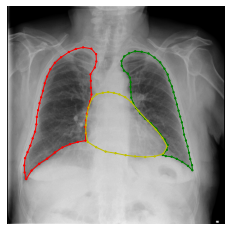

In [8]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import pathlib
import re

def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

data_root = pathlib.Path("Images/")
all_files = list(data_root.glob('*.png'))
all_files = [str(path) for path in all_files]
all_files.sort(key = natural_key)

img1 = all_files[0]
RL = img1.replace('Images','landmarks/RL').replace('.png','.npy')
LL = img1.replace('Images','landmarks/LL').replace('.png','.npy')
H = img1.replace('Images','landmarks/H').replace('.png','.npy')

img = cv2.imread(img1,0)
RL = np.load(RL)
LL = np.load(LL)
H = np.load(H)

drawOrgans(RL,LL,H,img)

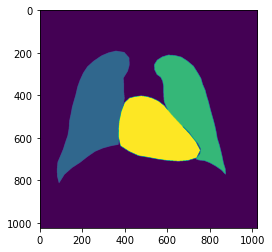

In [9]:
def getDenseMask(RL, LL, H = None, imagesize = 1024):
    img = np.zeros([1024,1024])
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')

    img = cv2.drawContours(img, [RL], -1, 1, -1)
    img = cv2.drawContours(img, [LL], -1, 2, -1)
    
    if H is not None:
        H = H.reshape(-1, 1, 2).astype('int')
        img = cv2.drawContours(img, [H], -1, 3, -1)
    
    return img

aux = getDenseMask(RL,LL,H)
plt.imshow(aux)

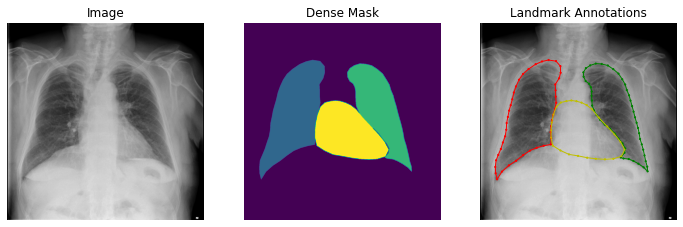

In [16]:
plt.figure(figsize = (12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(aux)
plt.title('Dense Mask')
plt.axis('off')
ax = plt.subplot(1,3,3)
drawOrgans(RL,LL,H,img,ax)
plt.title('Landmark Annotations')
plt.savefig('landmarks.png', dpi = 200)

In [39]:
import pandas as pd
import os

clinical = pd.read_csv('clinical.csv')

In [ ]:
del clinical["Unnamed: 0"]

In [41]:
lista_lung = []

for file in clinical['File']:
    path = os.path.join('landmarks/RL', file.replace('.png','.npy'))
    lista_lung.append(os.path.exists(path))    
    
lista_heart = []

for file in clinical['File']:
    path = os.path.join('landmarks/H', file.replace('.png','.npy'))
    lista_heart.append(os.path.exists(path))    

In [42]:
clinical.insert(2, "Lung Annotations", lista_lung)

In [43]:
clinical.insert(3, "Heart Annotations", lista_heart)

In [44]:
clinical

,File,Dataset,Lung Annotations,Heart Annotations,Sex,Age,Condition
0,1256842362861431725328351539259305635_u1qifz.png,Padchest,True,True,M,90,"['aortic elongation', 'vertebral degenerative ..."
1,10155709300728342918543955138521808206_f7cj92.png,Padchest,True,True,F,79,"['nodule', 'pleural effusion', 'chronic change..."
2,10287653421930576798556842610982533460_vpbhw6.png,Padchest,True,True,F,71,"['diaphragmatic eventration', 'cardiomegaly']"
3,10383960670432673238945376919735423432_hd3moq.png,Padchest,True,True,M,79,['cardiomegaly']
4,10996416492353037588312781035930080694_8rstz0.png,Padchest,True,True,F,85,"['pacemaker', 'cardiomegaly']"
...,...,...,...,...,...,...,...
906,MCUCXR_0383_1.png,Montgomery,True,False,F,14,calcified granuloma LUL behind 4th rib anterior
907,MCUCXR_0387_1.png,Montgomery,True,False,M,42,inactive scars RUL
908,MCUCXR_0390_1.png,Montgomery,True,False,M,52,Rt apical scarring. LUL scars and some infiltr...
909,MCUCXR_0393_1.png,Montgomery,True,False,F,30,left pleural effusion; best seen on lateral vi...


In [45]:
clinical.to_csv('clinical.csv', index = False)